In [207]:
from numpy import interp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from collections import Counter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

In [208]:
from pprint import pprint
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

In [209]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectKBest
import pickle

In [210]:
comp = pd.read_csv('C:/Users/daswa/Desktop/Data Science Projects/Healthcare_Startup_Assessment/data_store/processed/final_data_companies_social_media.csv')
comp = comp[comp.stage.notna() 
     & comp.name.notna() & comp["size_numeric"].notna()]
comp['market'] = comp['market'].apply(lambda row: str(row).replace(" ", "_"))

In [211]:
comp.head()

,joined,kind,link,location,market,name,Unnamed: 6,raised,size,stage,website,years,annual_raised,raised_2mil,raised_12mil,size_numeric,followers,following
0,5/1/2012,Startup,https://angel.co/company/ginx,Las Vegas,Mobile_Commerce,*Ginx,NaN,700000,10-Jan,Seed,ginxapp.com,7.627397,9.177443e+04,0,0,5.0,57,74
1,10/1/2012,Startup,https://angel.co/company/1world-1,Redwood City,Polling,1World Online,NaN,7280000,10-Jan,Series A,1worldonline.com,7.208219,1.009958e+06,1,0,5.0,5643,1427
2,8/1/2014,Startup,https://angel.co/company/21,San Francisco,Bitcoin,21,NaN,116000000,Nov-50,Seed,21.co,5.375342,2.158002e+07,1,1,25.0,0,0
3,9/1/2013,Startup,https://angel.co/company/24sessions,Amsterdam,Developer_APIs,24sessions,NaN,135000,Nov-50,Seed,24sessions.com,6.290411,2.146124e+04,0,0,25.0,2657,3032
4,2/1/2016,Startup,https://angel.co/company/2morrow,Seattle,B2B,2Morrow,NaN,350000,Nov-50,Seed,2morrowinc.com,3.871233,9.041047e+04,0,0,25.0,1244,916


In [212]:
seed = comp[(comp["stage"]=="Seed")]
seed_y = seed['raised_2mil']

seriesA = comp[(comp["stage"]=="Series A")]
seriesA_y = seriesA['raised_12mil']

In [213]:
def one_hot(dataframe, nominal):
    gen_onehot_features = pd.get_dummies(dataframe[nominal])
    result = pd.concat([dataframe, gen_onehot_features],axis=1)
    result.drop([nominal],axis=1,inplace=True)
    result.drop(result.columns[(result == 0).sum() > 0.995*result.shape[0]], axis = 1, inplace = True) 
    return result

In [283]:
include_followers = 1
feature_list = ['location','size_numeric','years','market']

if(include_followers):
    feature_list = feature_list + ['followers']


seed_x =one_hot(one_hot(seed[feature_list],"location"),"market")
seriesA_x =one_hot(one_hot(seriesA[feature_list],"location"),"market")


In [284]:
rs = 3

seed_x_train, seed_x_test, seed_y_train, seed_y_test = train_test_split(seed_x, 
                                                                        seed_y, 
                                                                        test_size=0.2,
                                                                        random_state=rs)

seriesA_x_train, seriesA_x_test, seriesA_y_train, seriesA_y_test = train_test_split(seriesA_x, 
                                                                                    seriesA_y, 
                                                                                    test_size=0.2, 
                                                                                    random_state=rs)

In [285]:
def get_feat(method, k, x, y):
    select = SelectKBest(method, k)
    _ = select.fit_transform(x, y)
    return [x.columns[i] for i, val in enumerate(select.get_support()) if val]

num_features = 10

In [286]:
chi2_seed = get_feat(chi2, num_features, seed_x_train, seed_y_train)

In [287]:
chi2_seed

['size_numeric',
 'years',
 'followers',
 'Austin',
 'San Francisco',
 'Enterprise_Security',
 'Fantasy_Sports',
 'Mobile_Games',
 'Predictive_Analytics',
 'Social_Media']

In [288]:
chi2_seriesA = get_feat(chi2, num_features, seriesA_x_train, seriesA_y_train)

In [289]:
chi2_seriesA

['size_numeric',
 'years',
 'followers',
 'Seattle',
 'Application_Platforms',
 'Banking',
 'Consumer_Electronics',
 'Data_Security',
 'Fitness',
 'Investment_Management']

In [290]:
def downsample_split(X,y):
    var= y.name
    #combine them for resampling
    train_data = pd.concat([X, y], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    
    X_train, X_test, y_train, y_test = train_test_split( 
        upsampled.drop(var,axis=1), upsampled[var], stratify=upsampled[var],
        test_size=0.33,)
    
    return X_train, X_test, y_train, y_test

In [291]:
def downsample(X,y,rs=None):
    var= y.name
    
    joint = pd.concat([X, y], axis=1)
    negative = joint[joint[var]==0]
    positive = joint[joint[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        random_state = rs) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X = upsampled.drop(var,axis=1)
    new_y = upsampled[var]
    
    return new_X, new_y

In [292]:
def split_downsample(X,y):
    var= y.name
    #split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33)
    #combine them back for resampling
    train_data = pd.concat([X_train, y_train], axis=1)
    # separate minority and majority classes
    negative = train_data[train_data[var]==0]
    positive = train_data[train_data[var]==1]

    # downsample majority
    neg_downsampled = resample(negative,
        replace=True, # sample with replacement
        n_samples=len(positive), # match number in minority class
        ) # reproducible results
    
    
    # combine majority and upsampled minority
    upsampled = pd.concat([neg_downsampled, positive])
    # check new class counts
    
    new_X_train = upsampled.drop(var,axis=1)
    new_y_train = upsampled[var]
    
    return new_X_train, X_test, new_y_train, y_test

In [293]:
colors=['red','royalblue']

In [294]:
def scikit_logi(X,y,samplemethod):
    # Splits x,y into testing and validation sets, and return the fpr and tpr of the validation set 
    X_train, X_test, y_train, y_test = samplemethod(X, y)
    logi = LogisticRegression(solver='lbfgs',max_iter=1000)
    model = logi.fit(X_train,y_train)
    y_pred_proba = model.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:,1])
    return (fpr, tpr)

In [295]:
def logi_plot_roc(x,y,c,show_detail=False,txtlabel=""):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    for i in range(100):
        fpr_R_seed_sel, tpr_R_seed_sel = scikit_logi(x,y, split_downsample)
        if show_detail == True:
            plt.plot(fpr_R_seed_sel, tpr_R_seed_sel, lw=0.1, color = c, alpha=0.6)

        interp_tpr = interp(mean_fpr, fpr_R_seed_sel, tpr_R_seed_sel)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr_R_seed_sel,tpr_R_seed_sel))

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color=c,
            label=txtlabel+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
            lw=2, alpha=0.8)

    if show_detail == True:
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.3,
                        label=r'$\pm$ 1 std. dev.')
    return(mean_fpr, mean_tpr, mean_auc, std_auc)

In [296]:
def label():
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")

## Without Follower's training modeling results

## Seed Model

Text(0.5, 1.0, 'Logi (chi2/f) Mean ROC')

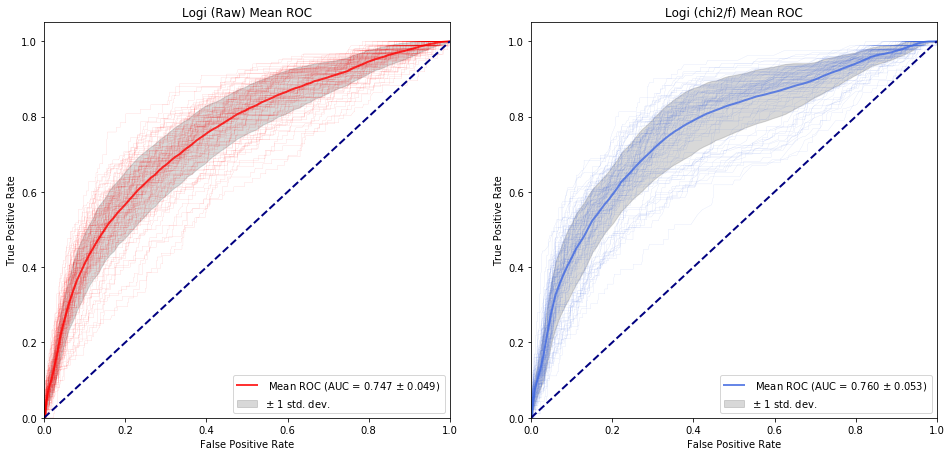

In [274]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seed_x_train,seed_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seed_x_train[chi2_seed],seed_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")



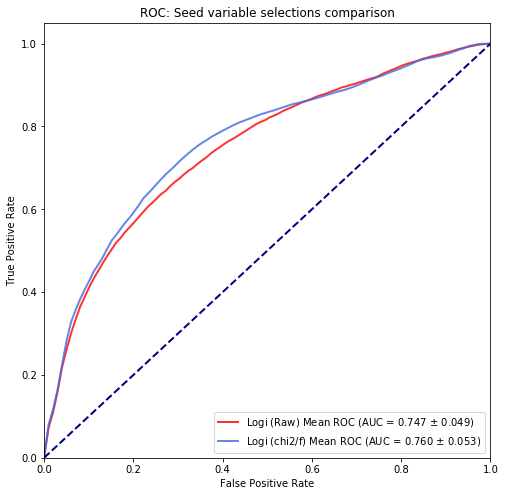

In [275]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[1], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: Seed variable selections comparison")
plt.savefig('seed_all.png')


plt.show()

## Series A model

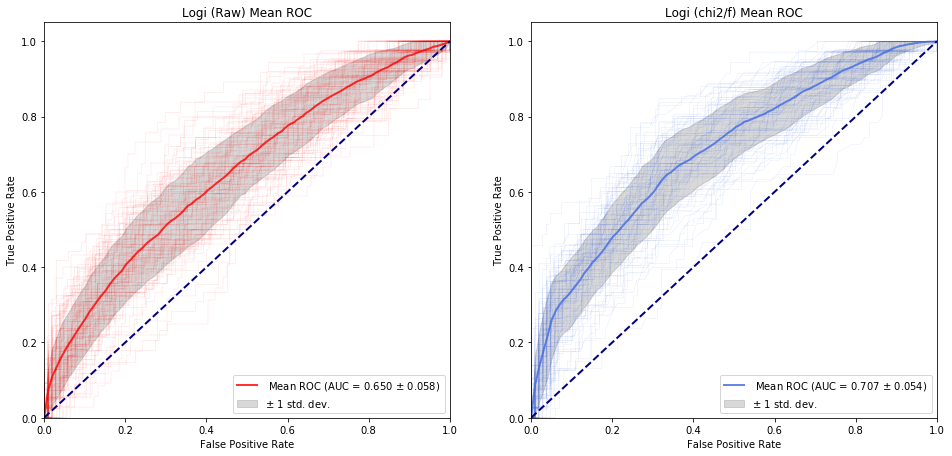

In [276]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seriesA_x_train,seriesA_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")


ax = fig.add_subplot(2, 2, 2)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seriesA_x_train[chi2_seriesA],seriesA_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

plt.savefig('seriesA_4x.png')

plt.show()

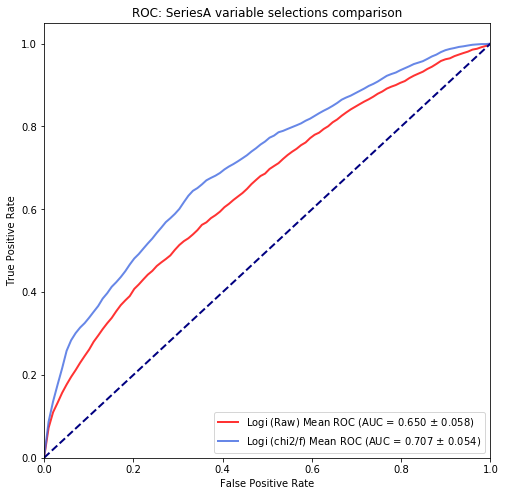

In [277]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)

plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[1], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: SeriesA variable selections comparison")
plt.savefig('seriesA_all.png')


plt.show()

## With Follower's training model results

## Seed Model

Text(0.5, 1.0, 'Logi (chi2/f) Mean ROC')

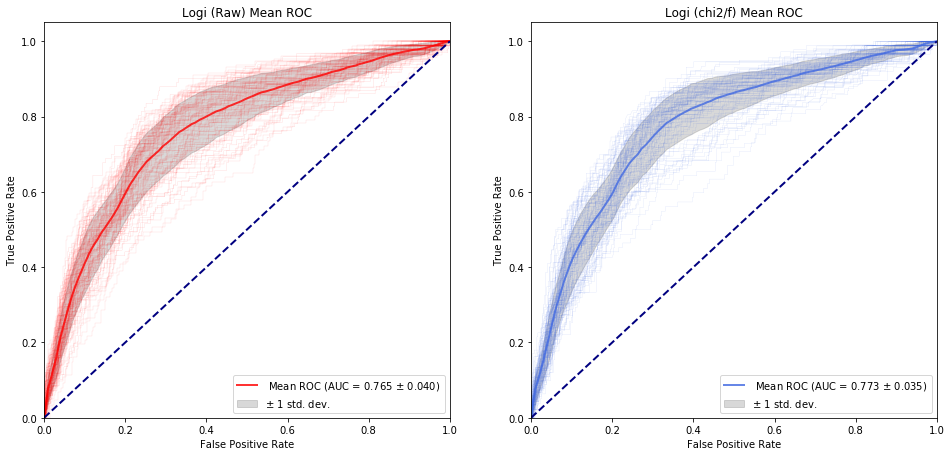

In [250]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seed_x_train,seed_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")

ax = fig.add_subplot(2, 2, 2)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seed_x_train[chi2_seed],seed_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")



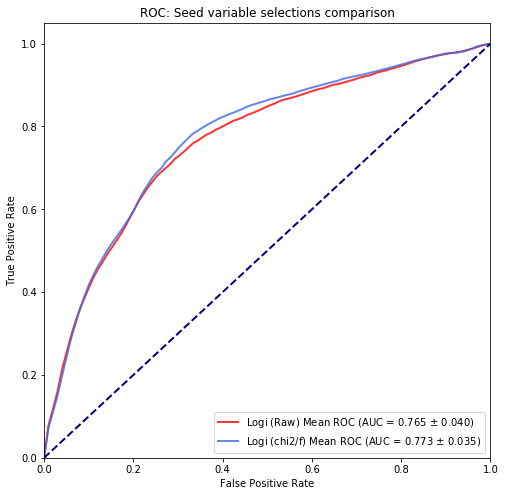

In [251]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)
plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[1], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: Seed variable selections comparison")
plt.savefig('seed_all.png')


plt.show()

## Series A model

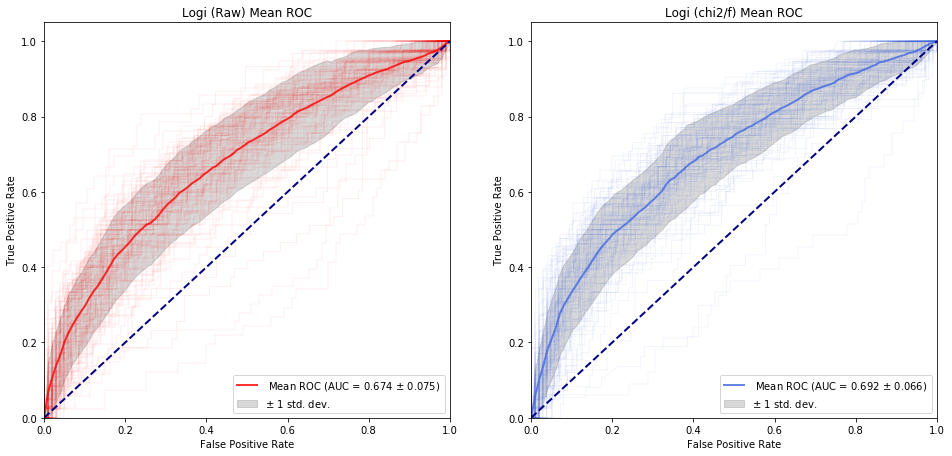

In [297]:
fig = plt.figure(figsize=(16,16))
fig.subplots_adjust(hspace=0.2, wspace=0.2)


ax = fig.add_subplot(2, 2, 1)
c1_mean_fpr, c1_mean_tpr, c1_mean_auc, c1_std_auc = logi_plot_roc(seriesA_x_train,seriesA_y_train,colors[0],show_detail=True)
label()
plt.title("Logi (Raw) Mean ROC")


ax = fig.add_subplot(2, 2, 2)
c3_mean_fpr, c3_mean_tpr, c3_mean_auc, c3_std_auc = logi_plot_roc(seriesA_x_train[chi2_seriesA],seriesA_y_train,colors[1],show_detail=True)
label()
plt.title("Logi (chi2/f) Mean ROC")

plt.savefig('seriesA_4x.png')

plt.show()

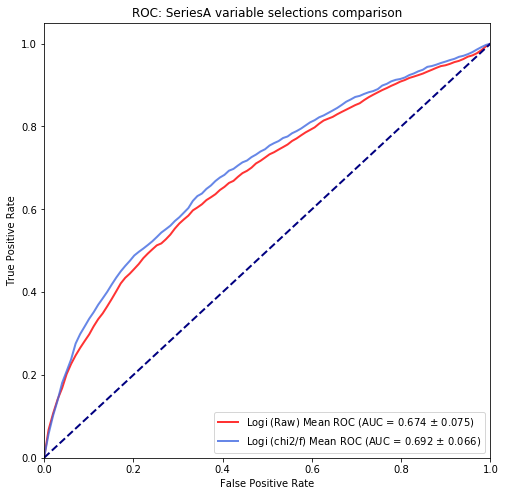

In [298]:
fig = plt.figure(figsize=(8,8))

plt.plot(c1_mean_fpr, c1_mean_tpr, color=colors[0], label="Logi (Raw)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c1_mean_auc, c1_std_auc), lw=2, alpha=0.8)

plt.plot(c3_mean_fpr, c3_mean_tpr, color=colors[1], label="Logi (chi2/f)"+ r' Mean ROC (AUC = %0.3f $\pm$ %0.3f)' 
         % (c3_mean_auc, c3_std_auc), lw=2, alpha=0.8)

label()

plt.title("ROC: SeriesA variable selections comparison")
plt.savefig('seriesA_all.png')


plt.show()

In [254]:
def test_results(x_train, y_train, x_test, y_test, filename):
    x_train, y_train = downsample(x_train, y_train,rs)
    logi = LogisticRegression(solver='lbfgs',max_iter=1000)
    logi.fit(x_train, y_train)
    acc = logi.score(x_test, y_test)
    y_pred = logi.predict(x_test)
    cm = confusion_matrix(y_test, y_pred,labels=[1, 0])
    tpr = cm[0][0]/np.sum(cm[0])
    tnr = cm[1][1]/np.sum(cm[1])
    
    # save the model to disk
    pickle.dump(logi, open(filename, 'wb'))
    
    print(classification_report(y_test, y_pred))
    
    return(list(np.round([acc,tpr,tnr],3)))

## Test Results for Seed Model

In [234]:
data = []

In [235]:
data = data + [ ["Seed_without_Followers Chi2/F"] + 
               test_results(seed_x_train[chi2_seed], 
                            seed_y_train, 
                            seed_x_test[chi2_seed], 
                            seed_y_test,'seed.sav')]

              precision    recall  f1-score   support

           0       0.91      0.71      0.80       316
           1       0.33      0.67      0.44        67

    accuracy                           0.70       383
   macro avg       0.62      0.69      0.62       383
weighted avg       0.81      0.70      0.74       383



In [255]:
data = data + [ ["Seed_with_Followers Chi2/F"] + 
               test_results(seed_x_train[chi2_seed], 
                            seed_y_train, 
                            seed_x_test[chi2_seed], 
                            seed_y_test,'seed_followers.sav')]

              precision    recall  f1-score   support

           0       0.93      0.75      0.83       316
           1       0.39      0.75      0.51        67

    accuracy                           0.75       383
   macro avg       0.66      0.75      0.67       383
weighted avg       0.84      0.75      0.78       383



In [256]:
df = pd.DataFrame(data, columns = ['Method','Test Accuracy', 'TPR', "TNR"]) 
df

,Method,Test Accuracy,TPR,TNR
0,Seed_without_Followers Chi2/F,0.705,0.672,0.712
1,Seed_with_Followers Chi2/F,0.749,0.746,0.750


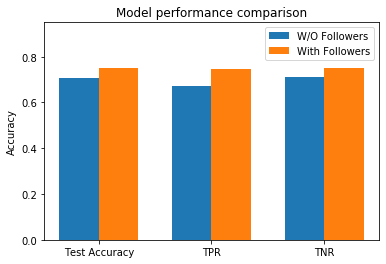

In [257]:
N = 3
width = 0.35 
pos = np.arange(N)

plt.bar(pos,df[['Test Accuracy','TPR','TNR']].iloc[0],width, label = 'W/O Followers')
plt.bar([p + width for p in pos],df[['Test Accuracy','TPR','TNR']].iloc[1],width, label='With Followers')

plt.ylabel('Accuracy')
plt.ylim([0, 0.95])

plt.xticks(pos + width / 2, ('Test Accuracy','TPR','TNR'))
plt.legend(loc='best')
plt.title("Model performance comparison")
plt.show()


## Test results for Series A model

In [281]:
data_SeriesA = []

In [282]:
data_SeriesA = data_SeriesA + [["SeriesA Without Followers"] + 
                               test_results(seriesA_x_train[chi2_seriesA], 
                                            seriesA_y_train, 
                                            seriesA_x_test[chi2_seriesA], 
                                            seriesA_y_test,'SeriesA.sav')]

              precision    recall  f1-score   support

           0       0.76      0.69      0.72        74
           1       0.42      0.52      0.47        33

    accuracy                           0.64       107
   macro avg       0.59      0.60      0.59       107
weighted avg       0.66      0.64      0.64       107



In [299]:
data_SeriesA = data_SeriesA + [["SeriesA With Followers"] + 
                               test_results(seriesA_x_train[chi2_seriesA], 
                                            seriesA_y_train, 
                                            seriesA_x_test[chi2_seriesA], 
                                            seriesA_y_test,'SeriesA_followers.sav')]

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        74
           1       0.45      0.45      0.45        33

    accuracy                           0.66       107
   macro avg       0.61      0.61      0.61       107
weighted avg       0.66      0.66      0.66       107



In [300]:
df_seriesA = pd.DataFrame(data_SeriesA, columns = ['Method','Test Accuracy', 'TPR', "TNR"]) 
df_seriesA

,Method,Test Accuracy,TPR,TNR
0,SeriesA Without Followers,0.636,0.515,0.689
1,SeriesA With Followers,0.664,0.455,0.757


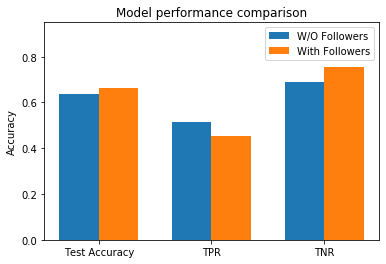

In [301]:
N = 3
width = 0.35 
pos = np.arange(N)

plt.bar(pos,df_seriesA[['Test Accuracy','TPR','TNR']].iloc[0],width, label = 'W/O Followers')
plt.bar([p + width for p in pos],df_seriesA[['Test Accuracy','TPR','TNR']].iloc[1],width, label='With Followers')

plt.ylabel('Accuracy')
plt.ylim([0, 0.95])

plt.xticks(pos + width / 2, ('Test Accuracy','TPR','TNR'))
plt.legend(loc='best')
plt.title("Model performance comparison")
plt.show()


In [108]:
[list(seed_x_test[chi2_seed].iloc[102])]

[[5.0, 6.709589041, 5765.0, 16.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [110]:
[[5,6,10000,16,1,0,0,0,0,0]]

[[5, 6, 10000, 16, 1, 0, 0, 0, 0, 0]]

In [135]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open('../models/seed_followers.sav', 'rb'))
#result = loaded_model.score(seed_x_test[chi2_seed].iloc[11], seed_y_test.iloc[11])
result = loaded_model.predict([[5,5,1112000,1000,1,0,0,0,0,0]])
print(result)
    

[1]


In [68]:
seed_y_test.iloc[10]

0

In [304]:
chi2_seed

['size_numeric',
 'years',
 'followers',
 'Austin',
 'San Francisco',
 'Enterprise_Security',
 'Fantasy_Sports',
 'Mobile_Games',
 'Predictive_Analytics',
 'Social_Media']

In [305]:
import statsmodels.api as sm
logi = sm.Logit(seed_y_train, seed_x_train[chi2_seed]).fit(method='bfgs',maxiter=1000) 

         Current function value: 0.693147
         Iterations: 0
         Function evaluations: 16
         Gradient evaluations: 4


C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\Users\daswa\anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [306]:
logi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            raised_2mil   No. Observations:                 1529
Model:                          Logit   Df Residuals:                     1519
Method:                           MLE   Df Model:                            9
Date:                Sun, 21 Jun 2020   Pseudo R-squ.:                 -0.4711
Time:                        23:31:27   Log-Likelihood:                -1059.8
converged:                      False   LL-Null:                       -720.43
Covariance Type:            nonrobust   LLR p-value:                     1.000
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
size_numeric                  0      0.000          0      1.000      -0.000       0.000
years                         0      0.009          0      1.000      -0.018       0.018
followers                     0   1.74e-06          0      1.000   -3.42e-06    3.42e-06
Austin                        0      0.413          0      1.000      -0.809       0.809
San Francisco                 0      0.150          0      1.000      -0.293       0.293
Enterprise_Security           0      0.670          0      1.000      -1.313       1.313
Fantasy_Sports                0      0.502          0      1.000      -0.985       0.985
Mobile_Games                  0      0.310          0      1.000      -0.607       0.607
Predictive_Analytics          0      0.557          0      1.000      -1.092       1.092
Social_Media                  0      0.605          0      1.000      -1.187       1.187
========================================================================================
"""

In [181]:
seed.groupby('location').value_counts()

AttributeError: 'DataFrameGroupBy' object has no attribute 'value_counts'

In [182]:
seed.columns

Index(['joined', 'kind', 'link', 'location', 'market', 'name', 'Unnamed: 6',
       'raised', 'size', 'stage', 'website', 'years', 'annual_raised',
       'raised_2mil', 'raised_12mil', 'size_numeric', 'followers',
       'following'],
      dtype='object')

In [203]:
x_train, y_train = downsample(x_train, y_train,rs)
logi = LogisticRegression(solver='lbfgs',max_iter=1000)
logi.fit(x_train, y_train)
acc = logi.score(x_test, y_test)
y_pred = logi.predict(x_test)
cm = confusion_matrix(y_test, y_pred,labels=[1, 0])
tpr = cm[0][0]/np.sum(cm[0])
tnr = cm[1][1]/np.sum(cm[1])

NameError: name 'x_train' is not defined

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))